In [1]:
import importlib
from numpy.core.numeric import Inf
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
from NNet.utils.writeNNet import writeNNet
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as patches
import time
import importlib
import models
import datasets
import math
import utils
from utils import *
import tasks

In [21]:
importlib.reload(datasets)
importlib.reload(tasks)

def training_all():
    task_classes = [
                    (tasks.BloomCrimeTask, 999), 
                    ]
    for task_class, time_out in task_classes:
        # print("task_class: ", task_class, "normal")
        # task_class(time_out = time_out).train_and_verify() # normal
        # print("task_class: ", task_class, "vanilla")
        # task_class(add_counterexample = True, incremental_training = True, time_out=time_out).train_and_verify() # vanilla
        print("task_class: ", task_class, "spec data")
        task_class(add_counterexample = True, incremental_training = True, batch_counterexample = True, time_out=time_out).train_and_verify() # spec data
        # print("task_class: ", task_class, "early reject")
        # task_class(add_counterexample = True, incremental_training = True, batch_counterexample = True, early_rejection = True, time_out=time_out).train_and_verify() # w/ early rejection
training_all()

task_class:  <class 'tasks.BloomCrimeTask'> early reject
Using cuda device
Epoch 1
-------------------------------
Train Error: 
 Accuracy: 79.9%, Avg loss: 1.425601 

time: 0.08012723922729492 999
Epoch 2
-------------------------------
Train Error: 
 Accuracy: 80.0%, Avg loss: 0.797797 

time: 0.15485262870788574 999
Epoch 3
-------------------------------
Train Error: 
 Accuracy: 85.4%, Avg loss: 0.624945 

time: 0.22994303703308105 999
Epoch 4
-------------------------------
Train Error: 
 Accuracy: 88.6%, Avg loss: 0.513376 

time: 0.30461668968200684 999
Epoch 5
-------------------------------
Train Error: 
 Accuracy: 89.9%, Avg loss: 0.473381 

time: 0.38153958320617676 999
Epoch 6
-------------------------------
Train Error: 
 Accuracy: 91.0%, Avg loss: 0.434089 

time: 0.4566054344177246 999
Epoch 7
-------------------------------
Train Error: 
 Accuracy: 91.6%, Avg loss: 0.419720 

time: 0.5330913066864014 999
Epoch 8
-------------------------------
Train Error: 
 Accuracy: 9

In [15]:
def append_neg_data(dataset, task, unit):
    for rect in task.safe_rects:
        size = (rect.hx - rect.lx) * (rect.hy - rect.ly)
        num_samples = int(np.ceil(size/unit))
        x = np.random.uniform(rect.lx, rect.hx, num_samples)
        y = np.random.uniform(rect.ly, rect.hy, num_samples)
        samples = np.vstack((x,y)).T
        for s in samples:
            dataset.append(s, np.zeros(1).astype('float32'))
    return dataset
def to_device(data, device):
    return tuple(tensor.to(device) for tensor in data) if isinstance(data, tuple) else data.to(device)
def test(model, data, batch_size, compute_loss, verbose=False, compute_error=False):
    dataloader = DataLoader(data, batch_size=batch_size)
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    digit_size, digit_correct = 0, 0
    positive = 0
    with torch.no_grad():
        for X, y in dataloader:
            X = to_device(X, "cuda")
            y = to_device(y, "cuda")
            if compute_error:
                acc_cnt, loss = compute_loss(model, X, y)
                test_loss += loss.cpu().item() if torch.is_tensor(loss) else loss
                correct += acc_cnt.cpu().item() if torch.is_tensor(acc_cnt) else acc_cnt
    if not compute_error:
        return None, None
    test_loss /= num_batches
    acc = correct * 1. / size
    if verbose:
        print(f"Test Error: \n Accuracy: {(100*acc):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return acc, test_loss
    
def accuracy_comparison(task_classes, verified):
    for task_class, time_out in task_classes:
        task = task_class(add_counterexample = verified, incremental_training = verified, batch_counterexample = verified, early_rejection = verified, time_out=time_out) # wo finetune
        task.load_model("../model/"+task.save_name+".pth")
        task.model.to("cuda")
        task.model.eval()
        neg_data = datasets.EmptyDataset()
        append_neg_data(neg_data, task, 0.0001)

        print(task.save_name)
        param_size = 0
        for param in task.model.parameters():
            param_size += param.nelement() * param.element_size()
        print('model size: {:.3f}KB'.format(param_size / 1024))

        ### latency ###
        batch_size=1
        start = time.time()
        _, _ = test(task.model, task.training_data, batch_size, task.compute_loss, compute_error = False)
        end = time.time()
        
        print("latency time (us): {:.5f}".format((end - start)/len(task.training_data)*1e6))
        # print("pos acc, loss: {:.5f}, {:.5f}".format(pos_acc, pos_loss))
        # print("neg acc, loss: {:.5f}, {:.5f}".format(neg_acc, neg_loss))
        
        ### throughput ###
        batch_size=len(task.training_data)
        rep_times = 100
        start = time.time()
        for i in range(rep_times):
            pos_acc, pos_loss = test(task.model, task.training_data, batch_size, task.compute_loss, compute_error = False)
        end = time.time()
        pos_acc, pos_loss = test(task.model, task.positive_data, batch_size, task.compute_loss, compute_error = True)
        neg_acc, neg_loss = test(task.model, neg_data, batch_size, task.compute_loss, compute_error = True)
        
        print("throughput: {:.5f}".format(len(task.training_data)/((end - start)/rep_times)))
        print("pos acc, loss: {:.5f}, {:.5f}".format(pos_acc, pos_loss))
        print("neg acc, loss: {:.5f}, {:.5f}".format(neg_acc, neg_loss))
        
accuracy_comparison([(tasks.BloomCrimeTask, 1000)], False)

BloomCrimeTask00000-1_1000
model size: 1964.848KB
latency time (us): 77.68761
throughput: 189691.71336
pos acc, loss: 0.99958, 0.04536
neg acc, loss: 0.75176, 0.85120


In [16]:
accuracy_comparison([(tasks.BloomCrimeTask, 1000)], True)

BloomCrimeTask11110-1_1000
model size: 1964.848KB
latency time (us): 76.70896
throughput: 190189.79052
pos acc, loss: 0.99958, 0.05924
neg acc, loss: 0.96681, 0.08859


In [8]:
training_data = datasets.CrimeDataset("../data/bloom_crime/crime.csv", test=False)

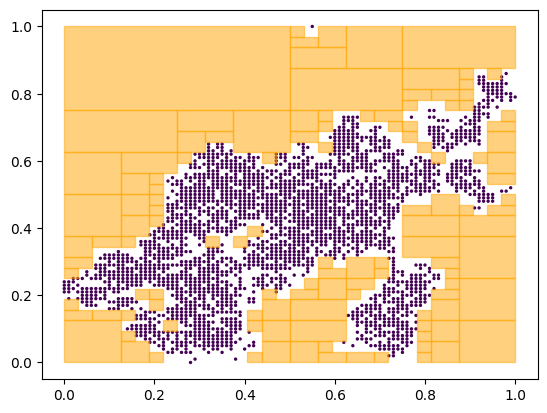

In [59]:
importlib.reload(datasets)
importlib.reload(tasks)
task = tasks.BloomCrimeTask(add_counterexample = True, incremental_training = True, batch_counterexample = True, early_rejection = True, time_out=300) # wo finetune


# task.draw(task.training_data)
# task.draw(neg_data)
# task.draw(task.testing_data)

In [14]:
import random

In [27]:
lx, hx = 1,2
ly, hy = 3,4
num_samples = 10
x = np.random.uniform(lx, hx, num_samples)
y = np.random.uniform(ly, hy, num_samples)

# combine the coordinates into a 2D array
samples = np.vstack((x,y)).T

In [32]:
samples[1]

array([1.2458493 , 3.42455296])

In [33]:
np.ceil(1.2)

2.0